# Blending two images together

In [11]:
import numpy as np
import cv2
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def downsample(image):
    '''reduce image by 1/2'''

    kernel = np.array([[1,  4,  6,  4, 1],
                       [4, 16, 24, 16, 4],
                       [6, 24, 36, 24, 6],
                       [4, 16, 24, 16, 4],
                       [1,  4,  6,  4, 1]])
    kernel = kernel/256.

    outimage = convolve2d(image, kernel, 'same')
    out = outimage[::2,::2]
    return out
 
def upsample(image):
    '''expand image by a factor of 2'''
    
    kernel = np.array([[1,  4,  6,  4, 1],
                       [4, 16, 24, 16, 4],
                       [6, 24, 36, 24, 6],
                       [4, 16, 24, 16, 4],
                       [1,  4,  6,  4, 1]])
    kernel = 4*kernel/256.   # The factor 4 is due to the zeros added to the array
                             # we want the average intensity to stay the same
    
    outimage = np.zeros((image.shape[0]*2, image.shape[1]*2), dtype=np.float64)
    outimage[::2,::2] = image[:,:]
    out = convolve2d(outimage, kernel, 'same')
    return out
 
def gauss_pyramid(image, num_levels):
    '''create a gaussain pyramid of a given image'''
    
    pyramid = []
    pyramid.append(image)
    level_img = image
    for i in range(0, num_levels):
        level_img = downsample(level_img)
        pyramid.append(level_img)
    return pyramid
 
def lapl_pyramid(gauss_pyr):
    '''build a laplacian pyramid from a gaussian pyramid'''
    
    pyramid = []
    num_levels = len(gauss_pyr)
    for i in range(0, num_levels-1):
        gauss_level_img = gauss_pyr[i]
        gauss_next_level_img = upsample(gauss_pyr[i+1])
        if gauss_next_level_img.shape[0] > gauss_level_img.shape[0]:
            gauss_next_level_img = np.delete(gauss_next_level_img,(-1),axis=0)
        if gauss_next_level_img.shape[1] > gauss_level_img.shape[1]:
            gauss_next_level_img = np.delete(gauss_next_level_img,(-1),axis=1)
        pyramid.append(gauss_level_img - gauss_next_level_img)
    pyramid.append(gauss_pyr[-1])
    return pyramid

def blend_pyramids(lapl_pyr1, lapl_pyr2, pyr_mask):
    '''Blend the two laplacian pyramids by weighting them according to a mask'''
    
    blended_pyr = []
    num_levels = len(pyr_mask)
    for i in range(0, num_levels):
        p1= pyr_mask[i]*lapl_pyr1[i]
        p2 = (1 - pyr_mask[i])*lapl_pyr2[i]
        blended_pyr.append(p1 + p2)
    return blended_pyr

def reconstruct(lapl_pyr):
    '''Reconstruct the image based on its laplacian pyramid.'''
    
    rec_img = np.zeros((lapl_pyr[0].shape[0],lapl_pyr[0].shape[1]), dtype=np.float64)
    num_levels = len(lapl_pyr)
    rec_level = lapl_pyr[-1]
    
    for i in range(num_levels-1, 0, -1):
        rec_level = upsample(rec_level)
        lapb = lapl_pyr[i-1]
        if rec_level.shape[0] > lapb.shape[0]:
            rec_level = np.delete(rec_level,(-1),axis=0)
        if rec_level.shape[1] > lapb.shape[1]:
            rec_level = np.delete(rec_level,(-1),axis=1)
        rec_level = rec_level + lapb
        
    return rec_level

def blend_imgs(image1, image2, mask):
    '''Blend two images. It is assumed that image sizes are equal'''
    
    # Automatically figure out the size
    min_size = min(image1.shape)
    num_levels = int(np.floor(np.log2(min_size))) - 4 # at least 16x16 at the highest level

    gauss_pyr_image1 = gauss_pyramid(image1, num_levels)
    gauss_pyr_image2 = gauss_pyramid(image2, num_levels)
    gauss_pyr_mask = gauss_pyramid(mask, num_levels)


    lapl_pyr_image1  = lapl_pyramid(gauss_pyr_image1)
    lapl_pyr_image2  = lapl_pyramid(gauss_pyr_image2)

    blended_pyr = blend_pyramids(lapl_pyr_image2, lapl_pyr_image1, gauss_pyr_mask)

    blended_img = reconstruct(blended_pyr)

    # blending sometimes results in slightly out of bound numbers
    blended_img[blended_img < 0] = 0
    blended_img[blended_img > 255] = 255
    blended_img = blended_img.astype(np.uint8)
    
    return blended_img

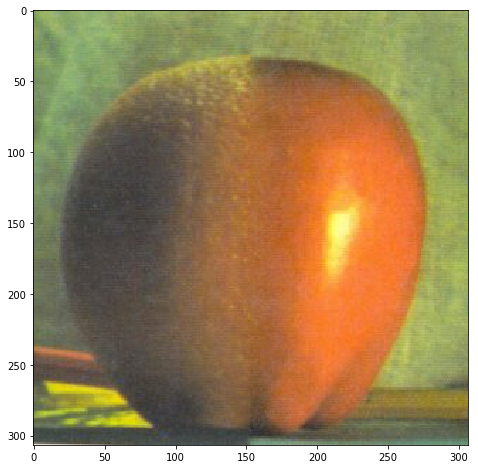

In [16]:

image1 = cv2.imread('apple.jpg', -1)
image2 = cv2.imread('orange.jpg', -1)
mask = np.zeros((image1.shape[0], image1.shape[1]))
mask[:,:mask.shape[1]//2] = 1     # Which part of the figure to merge

outimg = np.zeros_like(image1)
for i in range(3):
    outimg[:,:,i] = blend_imgs(image1[:,:,i], image2[:,:,i], mask)

plt.figure(figsize=[8, 8])
plt.imshow(outimg[:,:,::-1])


### What happens if we just concat the two images together

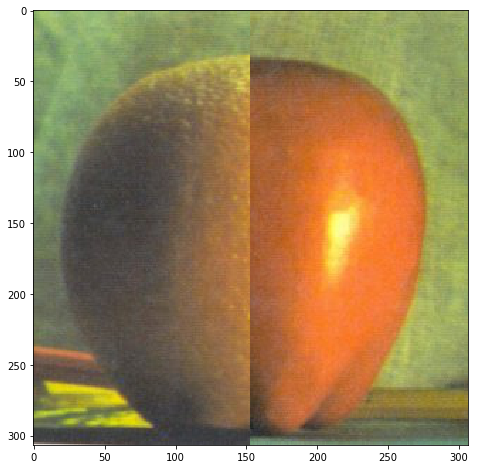

In [13]:
outimg_naive = np.zeros_like(image1)
for i in range(3):
    outimg_naive[:,:,i] = mask*image2[:,:,i] + (1-mask)*image1[:,:,i]

plt.figure(figsize=[8, 8])
plt.imshow(outimg_naive[:,:,::-1], 'gray')

### We can play around with the mask

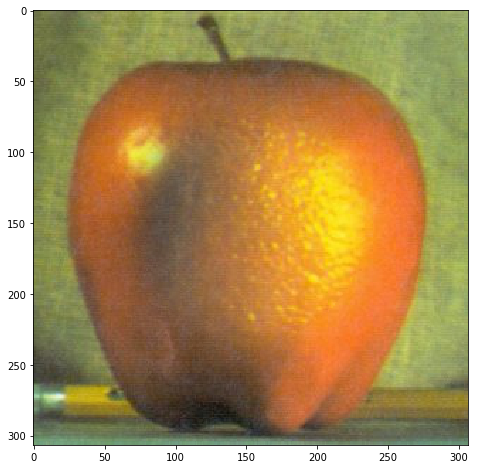

In [14]:
mask = np.zeros((image1.shape[0], image1.shape[1]))
for r in range(mask.shape[0]):
    for c in range(mask.shape[1]):
        d = np.sqrt((r-mask.shape[0]/2)**2 + (c-mask.shape[1]/2)**2)
        if d<80:
            mask[r,c] = 1

outimg = np.zeros_like(image1)
for i in range(3):
    outimg[:,:,i] = blend_imgs(image1[:,:,i], image2[:,:,i], mask)

plt.figure(figsize=[8, 8])
plt.imshow(outimg[:,:,::-1])